# Pricing Exotic Options with Tensorflow

In [41]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats
from   sklearn.linear_model import LinearRegression
from   sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def blackScholes_py(S_0, strike, time_to_expiry, implied_vol, riskfree_rate):
    S = S_0
    K = strike
    dt = time_to_expiry
    sigma = implied_vol
    r = riskfree_rate
    Phi = stats.norm.cdf
    d_1 = (np.log(S_0 / K) + (r + sigma**2/2) *dt) / (sigma * np.sqrt(dt))
    d_2 = d_1 - sigma*np.sqrt(dt)
    
    return S*Phi(d_1) - K*np.exp(-r*dt)*Phi(d_2)

In [3]:
def blackScholes_tf_pricer(S_0, strike, time_to_expiry, implied_vol, riskfree_rate):
    # Build the static computational graph
    S = tf.Variable(tf.convert_to_tensor(S_0, dtype=tf.float32))
    K = tf.Variable(tf.convert_to_tensor(strike, dtype=tf.float32))
    dt = tf.Variable(tf.convert_to_tensor(time_to_expiry, dtype=tf.float32))
    sigma = tf.Variable(tf.convert_to_tensor(implied_vol, dtype=tf.float32))
    r = tf.Variable(tf.convert_to_tensor(riskfree_rate, dtype=tf.float32))
    
    
    Phi = tfp.distributions.Normal(0.,1.).cdf
    d_1 = (tf.math.log(S / K) + (r+sigma**2/2)*dt) / (sigma*tf.math.sqrt(dt))
    d_2 = d_1 - sigma*tf.math.sqrt(dt)
    
    
    with tf.GradientTape() as tape:
        
        npv =  S*Phi(d_1) - K*tf.math.exp(-r*dt)*Phi(d_2)
        
    greeks = tape.gradient(npv, [S, sigma, r, K, dt])
    
    
    return npv, greeks
   
    

In [4]:
py_price = blackScholes_py(100., 110., 2., 0.2, 0.03)
print('pyt_price:', py_price)

tf_pricer = blackScholes_tf_pricer(100., 110., 2., 0.2, 0.03)
print("tf_price:", tf_pricer)

pyt_price: 9.73983632580859


W0718 01:44:55.507456  4888 deprecation.py:323] From C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\tensorflow_probability\python\internal\special_math.py:154: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


tf_price: (<tf.Tensor: id=110, shape=(), dtype=float32, numpy=9.739834>, [<tf.Tensor: id=113, shape=(), dtype=float32, numpy=0.5066146>, None, <tf.Tensor: id=122, shape=(), dtype=float32, numpy=81.84325>, <tf.Tensor: id=117, shape=(), dtype=float32, numpy=-0.37201476>, <tf.Tensor: id=121, shape=(), dtype=float32, numpy=1.2276486>])


# Monte Carlo with Tensorflow

In [5]:
def analytical_downOut_py(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, barrier):
    S = S_0
    K = strike
    dt = time_to_expiry
    sigma = implied_vol
    r = riskfree_rate
    alpha = 0.5 - r/sigma**2
    B = barrier
    
    Phi = stats.norm.cdf
    
    d_1 = (np.log(S / K) + (r + sigma**2/2)*dt) / (sigma * np.sqrt(dt))
    d_2 = d_1 - sigma*np.sqrt(dt)
    
    bs = S*Phi(d_1) - K * np.exp(-r*dt) * Phi(d_2)
    
    d_1a = (np.log(B**2 / (S * K)) - (r + sigma**2/2)*dt) / (sigma * np.sqrt(dt))
    d_2a = d_1a - sigma*np.sqrt(dt)
    
    reflection = (S/B)**(1 - r/sigma**2) * (B**2/S) * Phi(d_1a) - K * np.exp(-r*dt) * Phi(d_2a)
    
    return bs - reflection

In [6]:
analytical_downOut_py(100., 110., 2., 0.2, 0.03, 90)

7.895961199183238

In [7]:
def analytical_downOut_tf_pricer(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, barrier):
    
    S = tf.Variable(tf.convert_to_tensor(S_0, dtype=tf.float32))
    K = tf.Variable(tf.convert_to_tensor(strike, dtype=tf.float32))
    dt = tf.Variable(tf.convert_to_tensor(time_to_expiry, dtype=tf.float32))
    sigma = tf.Variable(tf.convert_to_tensor(implied_vol, dtype=tf.float32))
    r = tf.Variable(tf.convert_to_tensor(riskfree_rate, dtype=tf.float32))
    B = tf.Variable(tf.convert_to_tensor(barrier, dtype=tf.float32))
    
    Phi = tfp.distributions.Normal(0.,1.).cdf
   
    d_1 = (tf.math.log(S / K) + (r+sigma**2/2)*dt) / (sigma*tf.math.sqrt(dt))
    d_2 = d_1 - sigma*tf.math.sqrt(dt)
    
    d_1a = (tf.math.log(B**2 / (S * K)) - (r+sigma**2/2)*dt) / (sigma*tf.math.sqrt(dt))
    d_2a = d_1a - sigma*tf.math.sqrt(dt)
        
    with tf.GradientTape() as tape:
        
        bs_npv = S*Phi(d_1) - K*tf.math.exp(-r*dt)*Phi(d_2)
        
        reflection = (S/B)**(1 - r/sigma**2) * (B**2/S) * Phi(d_1a) - K * np.exp(-r*dt) * Phi(d_2a)
        
        npv = bs_npv - reflection
        
    greeks = tape.gradient(npv, [S, sigma, r, K, dt, B])
    
    
    return npv, greeks

In [8]:
analytical_downOut_tf_pricer(100., 110., 2., 0.2, 0.03, 90)

(<tf.Tensor: id=338, shape=(), dtype=float32, numpy=7.895957>,
 [<tf.Tensor: id=473, shape=(), dtype=float32, numpy=0.5537469>,
  <tf.Tensor: id=459, shape=(), dtype=float32, numpy=-4.965881>,
  <tf.Tensor: id=474, shape=(), dtype=float32, numpy=98.39618>,
  <tf.Tensor: id=475, shape=(), dtype=float32, numpy=-0.33164728>,
  <tf.Tensor: id=396, shape=(), dtype=float32, numpy=1.2276486>,
  <tf.Tensor: id=476, shape=(), dtype=float32, numpy=-0.12219474>])

In [25]:
def generate_random_variable_for_down_out(steps, samples, seed=44):
    np.random.seed(seed)
    return np.random.randn(samples, steps)

In [26]:
N = generate_random_variable_for_down_out(100, 1000000)
N.shape

(1000000, 100)

In [27]:
def monte_carlo_down_out_py(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, barrier, stdnorm_random_variates):
    
    S = S_0
    K = strike
    dt = time_to_expiry / stdnorm_random_variates.shape[1]
    sigma = implied_vol
    r = riskfree_rate
    B = barrier
    
    B_shift = B * np.exp(0.5826 * sigma * np.sqrt(dt))
    S_T = S * np.cumprod(np.exp((r - sigma**2/2)*dt + sigma*np.sqrt(dt)* stdnorm_random_variates), axis=1)
    non_touch = (np.min(S_T, axis=1) > B_shift) * 1
    call_payout = np.maximum(S_T[:, -1] - K, 0)
    npv = np.mean(non_touch*call_payout)
    
    return np.exp(-time_to_expiry*r) * npv


In [28]:
monte_carlo_down_out_py(100., 110., 2., 0.2, 0.03, 90., N)

7.121226486057998

In [37]:
def monte_carlo_down_out_tf(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, barrier, stdnorm_random_variates):
     
    S = tf.Variable(tf.convert_to_tensor(S_0, dtype=tf.float32))
    K = tf.Variable(tf.convert_to_tensor(strike, dtype=tf.float32))
    T = tf.Variable(tf.convert_to_tensor(time_to_expiry, dtype=tf.float32))
    dt = tf.Variable(tf.convert_to_tensor(T/ stdnorm_random_variates.shape[1], dtype=tf.float32))
    sigma = tf.Variable(tf.convert_to_tensor(implied_vol, dtype=tf.float32))
    r = tf.Variable(tf.convert_to_tensor(riskfree_rate, dtype=tf.float32))
    B = tf.convert_to_tensor(barrier, dtype=tf.float32)
    
    dw = tf.convert_to_tensor(stdnorm_random_variates, dtype=tf.float32)
    
    B_shift = B * tf.math.exp(0.5826 * sigma * tf.math.sqrt(dt))
    
    with tf.GradientTape() as tape:
    
        S_T = S * tf.math.cumprod(tf.math.exp((r - sigma**2/2)*dt + sigma*tf.math.sqrt(dt)* stdnorm_random_variates), axis=1)
        non_touch = tf.cast(tf.reduce_all(S_T > B_shift, axis=1), dtype=tf.float32)
        call_payout = tf.math.maximum(S_T[:, -1] - K, 0)
        npv = tf.math.exp(-r*T) * tf.reduce_mean(non_touch * call_payout)
        
    greeks = tape.gradient(npv, [S, sigma, r, K, T])
    
    return npv, greeks

In [38]:
monte_carlo_down_out_tf(100., 110., 2., 0.2, 0.03, 90., N)

(<tf.Tensor: id=1047, shape=(), dtype=float32, numpy=7.121201>,
 [<tf.Tensor: id=1083, shape=(), dtype=float32, numpy=0.32629073>,
  <tf.Tensor: id=1153, shape=(), dtype=float32, numpy=41.880886>,
  <tf.Tensor: id=1154, shape=(), dtype=float32, numpy=51.01574>,
  <tf.Tensor: id=1074, shape=(), dtype=float32, numpy=-0.23188975>,
  <tf.Tensor: id=1059, shape=(), dtype=float32, numpy=-0.21363603>])

In [48]:
def surface_plt(X,Y,Z, name='', angle=70):
    fig = plt.figure(figsize=(13,10))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z,cmap=plt.cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title('Down-And-Out Option (%s vs Barrier)' % name)
    ax.view_init(35, angle)
    ax.set_xlabel(name)
    ax.set_ylabel('barrier')
    ax.set_zlabel('price')
    plt.savefig('npv_%s_barrier.png' % name, dpi=300)

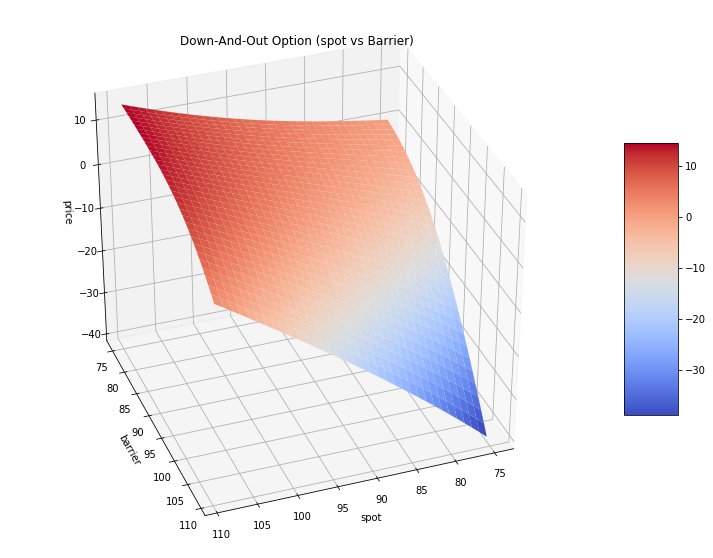

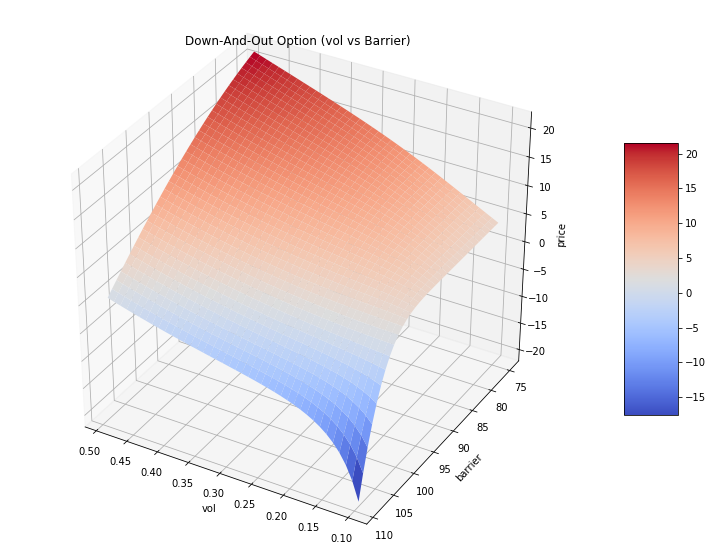

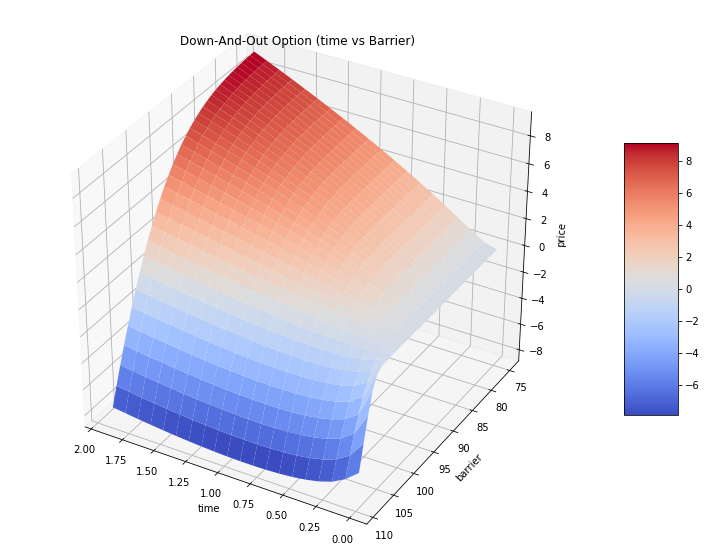

In [49]:
T = np.arange(0.01, 2, 0.1)
S = np.arange(75, 110, 1)
V = np.arange(0.1, 0.5, 0.01)
B = np.arange(75, 110, 1)
X, Y = np.meshgrid(S, B)
vectorized_do_pricer = np.vectorize(lambda s,b : analytical_downOut_py(s, 110., 2, 0.2, 0.03, b))
Z = vectorized_do_pricer(X, Y)
surface_plt(X,Y,Z,'spot', 70)
 
X, Y = np.meshgrid(V, B)
vectorized_do_pricer = np.vectorize(lambda x,y : analytical_downOut_py(100, 110., 2, x, 0.03, y))
Z = vectorized_do_pricer(X, Y)
surface_plt(X,Y,Z,'vol', 120)
 
X, Y = np.meshgrid(T, B)
vectorized_do_pricer = np.vectorize(lambda x,y : analytical_downOut_py(100, 110., x, 0.2, 0.03, y))
Z = vectorized_do_pricer(X, Y)
surface_plt(X,Y,Z,'time', 120)